This post is going to look at a useful non-parametric method for estimating the cumulative distribution distribution function (CDF) of a random variable called the [empirical distribution function](https://en.wikipedia.org/wiki/Empirical_distribution_function) (sometimes called the empirical CDF).  We'll talk a bit about the mechanics of computing it, some theory about its confidence intervals and also do some simulations to gain some intuition about how it behaves.

<!-- TEASER_END -->

## The Empirical Distribution Function

The most intuitive way to think about the empirical distribution function is that it relates to the CDF 
in a similar way to how a histogram relates to a probability density function.
Some figures (courtesy of Wikipedia) will help explain it better:  

![Normal vs. Cumulative Histogram (Wikipedia)](/images/Cumulative_vs_normal_histogram.svg.png)

The left figure shows a regular histogram on the left samples from what looks like normal distribution.  The right figure shows the same samples except each bin in the histogram contains the cumulative count of samples up to that bin, which approximates the shape of the CDF for this this random variable.  Now the right figure doesn't exactly represent an empirical distribution function because the Y-axis is not normalized to \\(1\\) and the samples are binned instead of just plotted cumulatively.  Nonetheless, the idea remains the same.  An example of an empirical CDF is given in the next figure (courtesy of Wikipedia):

![Empirical CDF (Wikipedia)](/images/Empirical_CDF.png)

This picture basically sums up the intuition about the empirical distribution function.  The blue line is our empirical CDF whereas the light grey one is our theoretical CDF.  Given just this picture you could probably figure out how to compute the empirical CDF but let's just state it formally.  

Let \\(X\\) be a random variable with CDF \\(F(x) = P(X \leq x)\\), and let \\( x_1,\ldots,x_n \\) be \\(n\\) [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_vawiables) random variables sampled from \\(X\\).  Then, the **empirical distribution function**, \\(\hat{F}(x)\\), is a CDF:

$$
\hat{F}(x) = \frac{\text{# of elements in sample} \leq x}{n} = \frac{1}{n} \Sigma_{i=1}^n I(x_i \leq x) \tag{1}
$$

where \\(I(\cdot)\\) is just the [indicator function](https://en.wikipedia.org/wiki/Indicator_function).

From this definition, we can derive some nice properties about the empirical CDF. For a fixed value of \\(x\\), \\(I(x_i \leq x)\\) is equivalent to a Bernoulli random variable with parameter \\(p = F(t)\\) (i.e. a coin flip with chance of heads \\(p\\)).  From this fact, the sum of these variables is equivalent to a binomial random variable, hence the mean and variance of \\(\hat{F}(x)\\):

\begin{align}
E[\hat{F}(x)] &= F(x) \\
Var[\hat{F}(x)] &= \frac{1}{n}F(x)(1-F(x)) \tag{2}
\end{align}

Since the expected value of \\(\hat{F}\\) converges to the value of the theoretical distribution (\\(F\\)), \\(\hat{F}\\) is a consistent estimator for the CDF by definition.  Another nice result due to the strong law of large numbers is that \\(\hat{F}_n(x)\\) converges to \\(F(x)\\) almost surely for every value of \\(x\\) as \\(n \rightarrow \infty\\).  An even strong result called the [Glivenko-Cantelli theorem](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem), states that this convergence happens uniformly across all \\(x\\).
All these results boil down to the fact that \\(\hat{F}(x)\\) is a good non-parametric estimator for the theoretical CDF \\(F\\).



## Confidence Intervals and Confidence Bands

The definition of a confidence interval can be extended to a function by considering \\(x\\) fixed and calculating a \\(1-\alpha\\) **pointwise confidence interval** about \\(x\\). Formally, \\(C(x)\\) defines the region defined by the pointwise confidence interval, given by:

\begin{align}
P(\{F(x) \in C(x)\}) \geq 1-\alpha \tag{3}
\end{align}

The issue with this pointwise definition is that each of the \\(x\\) values are computed independently.  So if we computed the pointwise confidence interval for each \\(x\\), any individual \\(x\\) would obey the confidence interval.  However, it would not guarantee that for each \\(x\\), \\(C(x)\\) simultaneously would be a \\(1-\alpha\\) confidence region because the guarantee is only for each point in isolation. 

Due to this issue, we can instead define a \\(1 - \alpha\\) **confidence band or confidence envelope** that is applied to all \\(x\\) (denoted by \\(B(x)\\)):

\begin{align}
P(\{F(x) \in B(x), \forall x\}) \geq 1-\alpha \tag{4}
\end{align}

Using a result called the [Dvoretzky-Kiefer-Wolfowitz (DKW) inequality](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality) [<sup>[1]</sup>](#fn-1), a two sided confidence band is given by the following:

\begin{align}
P(sup_{x\in \mathbb{R}} |F_n(x) - F(x)| > \epsilon) \leq 2e^{-2n\epsilon^2}
\end{align}

Notice that this defines the probability of being *outside* a particular band around \\(F(x)\\).  So setting the RHS to \\(\alpha\\), we can find an \\(\epsilon\\) to create a confidence band:

\begin{align}
\alpha &= 2e^{-2n\epsilon^2} \\
log(\frac{\alpha}{2}) &= -2n\epsilon^2 \\
log(\frac{2}{\alpha}) &= 2n\epsilon^2 \\
\epsilon &= \sqrt{\frac{1}{2n}log(\frac{2}{\alpha})} \tag{5}
\end{align}

Thus, we can define our confidence bands as such:

\begin{align}
L(x) &= max\{\hat{F}(x) - \epsilon, 0\} \\
U(x) &= min\{\hat{F}(x) + \epsilon, 1\} \tag{6}
\end{align}

Now that we have the theory for generating confidence bands, let's simulate some situations to see it in action.

## Simulation

The first step is to define some functions to help an empirical CDF, confidence bands, and to graph it.  Fortunately, [statsmodels](http://statsmodels.sourceforge.net/) has a nifty empirical CDF function to help us out.  

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tools.tools import ECDF

def epsilon(n, alpha=0.05):
   return np.sqrt(1. / (2. * n) * np.log(2. / alpha))

def plot_dist(rv, n, name, low, high, pltnum=111):
    samples = rv.rvs(n)
    ecdf = ECDF(samples)

    x = np.linspace(low, high, 10000)
    eps = epsilon(n=len(samples))
    df = pd.DataFrame(ecdf(x), index=x)
    df['ecdf'] = ecdf(x)
    df['cdf'] = rv.cdf(x)
    
    plt.subplot(pltnum)
    df['ecdf'].plot(label='ECDF')
    df['cdf'].plot(label='CDF', style='r--')
    df['upper'] = pd.Series(ecdf(x), index=x).apply(lambda x: min(x + eps, 1.))
    df['lower'] = pd.Series(ecdf(x), index=x).apply(lambda x: max(x - eps, 0.))
    plt.fill_between(x, df['upper'], df['lower'], 
                     alpha=0.1, label='Confidence Band')
    plt.legend(loc='best')
    plt.title('%s ECDF (n=%d)' % (name, len(samples)))


Now that we have some convenient helper functions, let's plot several different distributions to visually see how the confidence bands work.

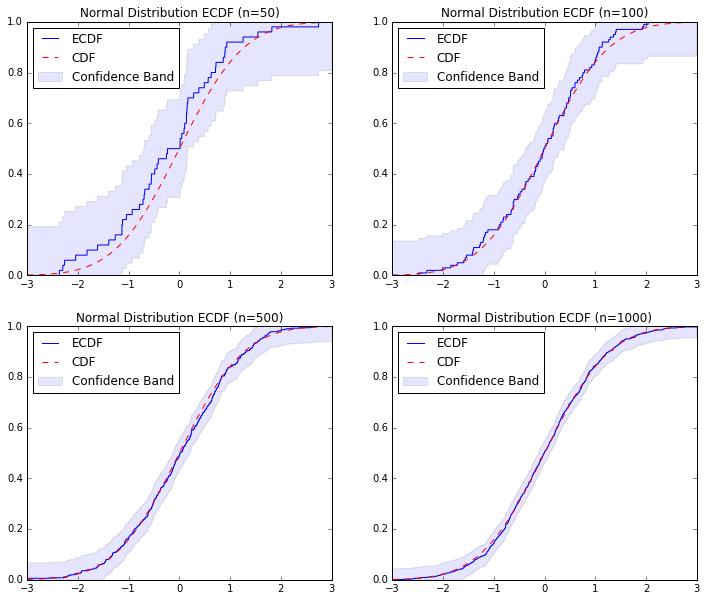

In [101]:
# Plot a normal ECDF and confidence bands
plt.figure(1, figsize=(12, 10))
norm = stats.norm(0., 1.)
plot_dist(norm, 50, name='Normal Distribution', low=-3, high=3, pltnum=221)
plot_dist(norm, 100, name='Normal Distribution', low=-3, high=3, pltnum=222)
plot_dist(norm, 500, name='Normal Distribution', low=-3, high=3, pltnum=223)
plot_dist(norm, 1000, name='Normal Distribution', low=-3, high=3, pltnum=224)
plt.show()

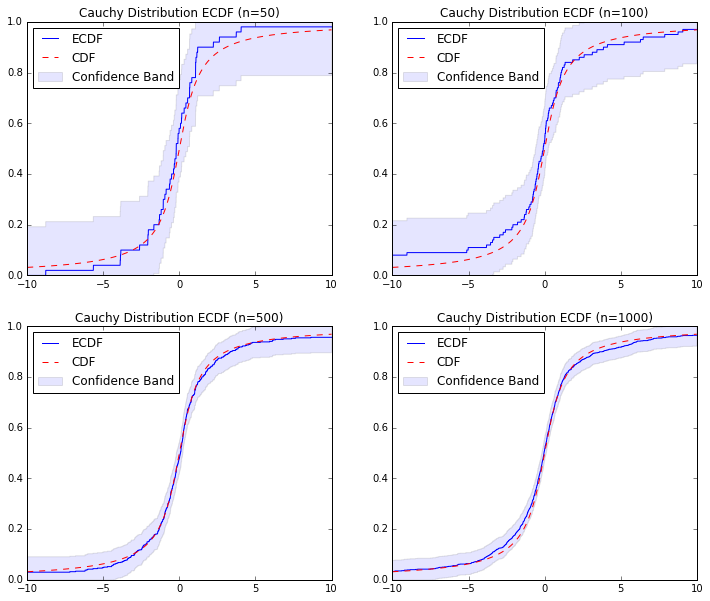

In [102]:
# Let's try another distribution: Cauchy
plt.figure(1, figsize=(12, 10))
cauchy = stats.cauchy()
plot_dist(cauchy, 50, name='Cauchy Distribution', low=-10, high=10, pltnum=221)
plot_dist(cauchy, 100, name='Cauchy Distribution', low=-10, high=10, pltnum=222)
plot_dist(cauchy, 500, name='Cauchy Distribution', low=-10, high=10, pltnum=223)
plot_dist(cauchy, 1000, name='Cauchy Distribution', low=-10, high=10, pltnum=224)
plt.show()

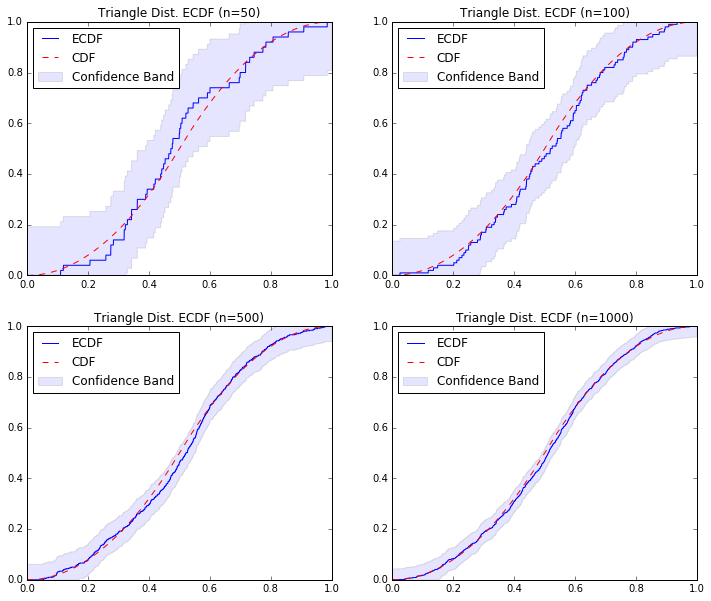

In [103]:
# And another: triangle
plt.figure(1, figsize=(12, 10))
triang = stats.triang(c=0.5)
plot_dist(triang, 50, name='Triangle Dist.', low=0, high=1, pltnum=221)
plot_dist(triang, 100, name='Triangle Dist.', low=0, high=1, pltnum=222)
plot_dist(triang, 500, name='Triangle Dist.', low=0, high=1, pltnum=223)
plot_dist(triang, 1000, name='Triangle Dist.', low=0, high=1, pltnum=224)
plt.show()

## Conclusion

The empirical distribution function is really a simple concept and is quite easy to understand once we plot it out and see some examples.  It's actually quite a good estimator for the CDF and has some nice properties such as being consistent and a known confidence band.  Best of all, it's non-parametric so it will work with pretty much any distribution you can throw at it.  This is just one of the many simple but useful results you usually don't learn in a the first few statistics course.  Better late than never!

## References and Further Reading

* Wikipedia: [Empirical Distribution Function](https://en.wikipedia.org/wiki/Empirical_distribution_function), [Histogram](https://en.wikipedia.org/wiki/Histogram), [Dvoretzky-Kiefer-Wolfowitz inequality](https://en.wikipedia.org/wiki/Dvoretzky%E2%80%93Kiefer%E2%80%93Wolfowitz_inequality)
* [The empirical distribution function](http://web.as.uky.edu/statistics/users/pbreheny/621/F10/notes/8-26.pdf), Patrick Breheny (University of Kentucky)

## Notes

List of Notes: [^1]

[^1]: What's extremely interesting about the DKW inequality is that it was first proved by its namesake in 1956 with an unspecified multiplicative constant \\(C\\) on the RHS exponent.  It was only recently in 1990 that Pascal Massart proved that \\(C=1\\) confirming a long held conjecture.  1990 is pretty darn recent (in mathematical result terms)!

